# Calculate height from pressure

We need virtual temperature (calculated from cdo - see <a href="../sh_scripts/cdo_mul.sh">cdo_mul.sh</a>)

$$ z_2-z_1 = \frac{287 \ T_v}{g} \cdot log(\frac{p_1}{p_2}) $$

where $p$ is pressure, $g = 9.8$ m/s$^2$, and $T_v$, virtual temperature, is

$$ T_v = (1 + 0.61 \ q_v) \ T $$

where $q_v$ is water vapor (specific humidity) and T is temperature. 



In [1]:
import xarray as xr
import dask
import numpy as np
import analysis_parameters as ap
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"

In [7]:
model="ARP"
if model=="SCREAM":
    chunk_dict={"time":100,"ncol":1000}
elif model=="ICON":
    chunk_dict={"time":100,"cell":1000}
elif model=="ARP":
    chunk_dict={"time":100,"rgrid":800}
else:
    chunk_dict={"time":100,"lat":1000, "lon":1000}
Tv = xr.open_dataset(ap.get_file(model, region=region+"_3D", var="Tv"), chunks=chunk_dict).hus
Tv_avg = (Tv[:,1:,:] + Tv[:,:-1,:].assign_coords(Tv[:,1:,:].coords))/2
Tv

<xarray.DataArray 'hus' (time: 232, lev: 60, rgrid: 202950)>
dask.array<open_dataset-06fcaaa2ef7256a50014274319f8465bhus, shape=(232, 60, 202950), dtype=float32, chunksize=(100, 60, 800), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28
    clon     (rgrid) float64 dask.array<chunksize=(800,), meta=np.ndarray>
    clat     (rgrid) float64 dask.array<chunksize=(800,), meta=np.ndarray>
  * lev      (lev) float64 16.0 17.0 18.0 19.0 20.0 ... 71.0 72.0 73.0 74.0 75.0
Dimensions without coordinates: rgrid
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific humidity
    units:          kg kg-1
    param:          0.1.0
    CDI_grid_type:  unstructured
    origin:         q

In [ ]:
Tv.mean(axis=(0,2)).plot()
plt.show()

In [8]:
if model=="SCREAM":
    p = Tv.lev.values
    logp = (np.log((p[1:]/p[:-1]))[np.newaxis,:,np.newaxis])*287/9.8
elif model=="UM":
    p = xr.open_dataset(ap.get_file("UM", region=region+"_3D", var="phalf"), chunks=chunk_dict).phalf
    logp = abs(np.log((p[:,1:].values/p[:,:-1].values)))
elif model=="ICON" or model=="ARP":
    p = xr.open_dataset(ap.get_file(model, region=region+"_3D", var="pa"), chunks=chunk_dict).pa
    logp = abs(np.log((p[:,1:].values/p[:,:-1].values)))
dz = 287*Tv_avg*logp/9.8

[########################################] | 100% Completed |  6min  3.3s
[########################################] | 100% Completed | 24.0s


In [9]:
z_dir = p[:,0].mean()-p[:,-1].mean() #first minus last pres, pos if bottom up, neg if top down

In [10]:
z_dir.compute()

[########################################] | 100% Completed | 21.5s


<xarray.DataArray 'pa' ()>
array(-95840.24, dtype=float32)

In [11]:
if z_dir<0:
    # top down
    z = dz[:,::-1,:].cumsum(axis=(1))[:,::-1,:]
elif z_dir>0:
    # bottom up
    z = dz.cumsum(axis=(1))
print(z.shape, Tv_avg.shape)

[########################################] | 100% Completed | 21.4s
(232, 59, 202950) (232, 59, 202950)


In [12]:
z = xr.Dataset({"zg":xr.DataArray(z, dims=Tv_avg.dims, 
                             attrs={"name":"zg","units":"m"})}, 
           attrs={"long_name":"geopotential height calculated from pressure","name":"height","units":"m"})
z.to_netcdf("/work/bb1153/b380883/TWP/TWP_3D_{}_zg_20200130-20200228.nc".format(model))
print("done")

[########################################] | 100% Completed | 11min 31.2s
done


[########################################] | 100% Completed | 49.6s


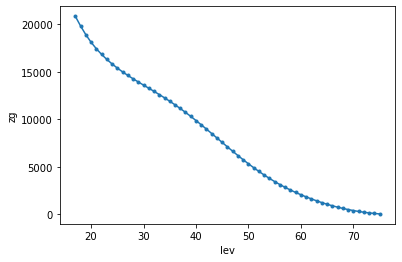

In [13]:
z.zg.mean(axis=(0,2)).plot(marker=".")
plt.show()

In [ ]:
z = xr.open_dataset("/work/bb1153/b380883/TWP/TWP_3D_ICON_zg_20200130-20200228.nc", chunks=chunk_dict).zg.mean(axis=(0,2)).plot(marker=".")

# Get pressure from height

\begin{align}{}
z_2-z_1 &= \frac{287 \ T_v}{g} \cdot log(\frac{p_1}{p_2}) \\
\frac{g}{287 \ T_v}dz &= log(\frac{p_1}{p_2}) \\
exp(\frac{g}{287 \ T_v}dz) &= \frac{p_1}{p_2} \\
p_2 &= \frac{p_1}{ exp(\frac{g}{287 \ T_v}dz) }
\end{align}

where $p_1$ is surface pressure given by the 2D output



## SAM

In [ ]:
ta = xr.open_dataset(ap.get_file("SAM","TWP_3D","ta"))
hus = xr.open_dataset(ap.get_file("SAM","TWP_3D","hus"))
z = ta.z





# Get pressure from pthick

```pfull = ps + pthick ```

## GEOS

In [ ]:
pthick = xr.open_dataset(ap.get_file("GEOS","TWP_3D","pthick"))
ps = xr.open_dataset(ap.get_file("GEOS","TWP_3D","pthick")).interp({'time':pthick.time, 'Xdim':pthick.Xdim})
print(ps.shape, ps.units, pthick.shape, pthick.units)

In [ ]:
pfull = pthick
pfull[:,0,:] = ps
for i in range(1,len(pfull.levs)):
    pfull[:,i,:] = pfull[:,i-1,:] + pthick[:,i,:]
pfull

In [ ]:
# test 
pfull.mean(axis=(0,2)).plot()
plt.show()

In [ ]:
xr.Dataset({"pfull":pfull},attrs={"standard_name":"pressure","units":"Pa"}